In [1]:
# --- 1. Import Libraries ---
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
sample_folder = '/home/ibab/Downloads/GSE128033_RAW/GSM3660641_SC14NOR'
prefix = 'GSM3660641_SC14NOR_' # Part of the filename before matrix.mtx, barcodes.tsv, etc.

# Load the count matrix, using gene symbols as names
adata = sc.read_10x_mtx(
    sample_folder,
    var_names='gene_symbols',
    cache=True, # Saves a cache file for faster loading next time
    prefix=prefix
)
print("Initial data shape:", adata.shape)

# --- Basic Filtering ---
# Remove cells with fewer than 200 genes (likely empty droplets)
print("Filtering cells...")
sc.pp.filter_cells(adata, min_genes=200)

# Remove genes detected in fewer than 5 cells (uninformative)
print("Filtering genes...")
sc.pp.filter_genes(adata, min_cells=5)
print("Shape after basic filtering:", adata.shape)

# --- Calculate QC Metrics ---
# Make sure gene names are unique (e.g., append '-1', '-2' if needed)
adata.var_names_make_unique()

# Find mitochondrial genes (names usually start with 'MT-')
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# Calculate metrics like total counts, genes/cell, mito %
print("Calculating QC metrics...")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Display first few rows of cell metadata with new QC columns
print("\nCell metadata with QC metrics (first 5 cells):")
print(adata.obs.head())

... reading from cache file cache/home-ibab-Downloads-GSE128033_RAW-GSM3660641_SC14NOR-GSM3660641_SC14NOR_matrix.h5ad
Initial data shape: (737280, 33694)
Filtering cells...
filtered out 736310 cells that have less than 200 genes expressed
Filtering genes...
filtered out 22801 genes that are detected in less than 5 cells
Shape after basic filtering: (970, 10893)
Calculating QC metrics...

Cell metadata with QC metrics (first 5 cells):
                  n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACCGTGGCGATT-1      601                596        1484.0             32.0   
AAACTTGACAGTTG-1      499                488        1287.0             19.0   
AAACTTGATCTCCG-1      353                350         736.0             21.0   
AAAGATCTTTACTC-1     1876               1862       11104.0            333.0   
AAAGGCCTAGAGAT-1      517                513        1253.0             18.0   

                  pct_counts_mt  
AAACCGTGGCGATT-1       2.156334  
AAACTTGACAGTTG-1   

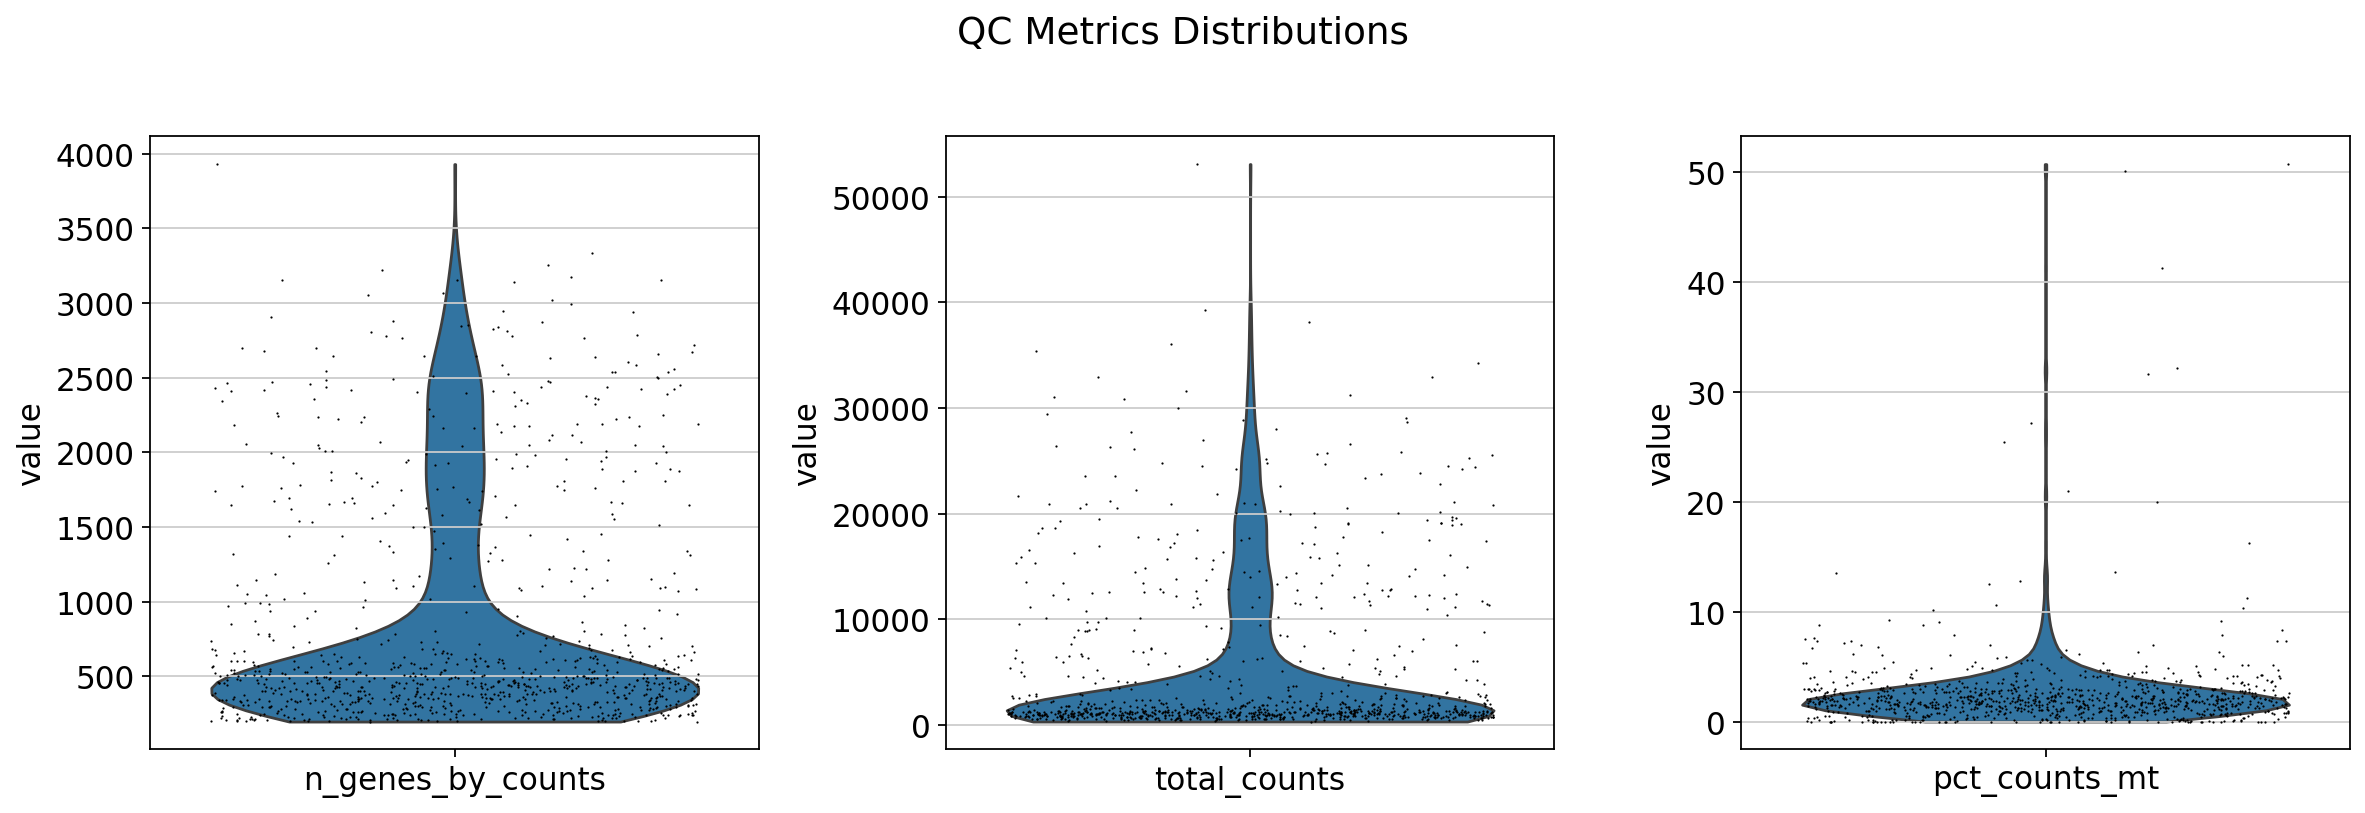

Cells before filtering: 970
Cells after filtering: 901


In [3]:
# Visualize QC metrics using violin plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4, ax=axs[0], show=False) # Genes per cell
sc.pl.violin(adata, ['total_counts'], jitter=0.4, ax=axs[1], show=False)      # UMIs per cell
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4, ax=axs[2], show=False)       # Mito % per cell
plt.suptitle("QC Metrics Distributions", y=1.02)
plt.tight_layout()
plt.show() # Display plots

# Define filtering thresholds based on plots
max_genes = 2500  # Threshold for potential doublets
max_mt_pct = 10   # Threshold for stressed/dying cells

# Apply filters
print(f"Cells before filtering: {adata.n_obs}") # Output: Cells before filtering: 970
adata = adata[adata.obs.n_genes_by_counts < max_genes, :] # Apply max genes filter
adata = adata[adata.obs.pct_counts_mt < max_mt_pct, :]     # Apply max mito % filter
print(f"Cells after filtering: {adata.n_obs}") # Output: Cells after filtering: 901

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/ibab/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


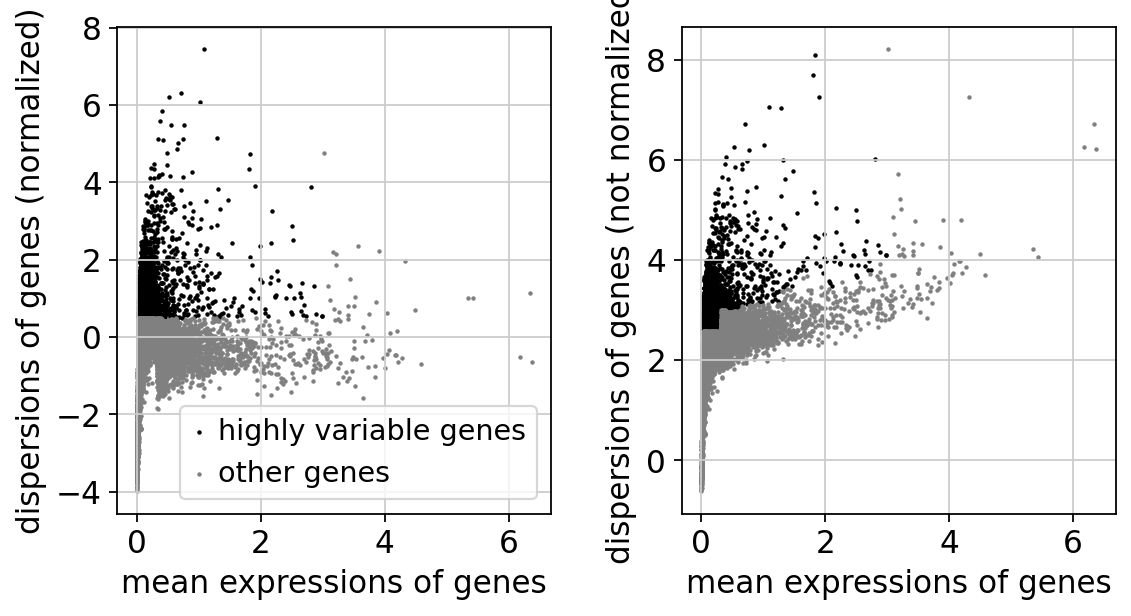

In [4]:
# Normalize counts per cell to 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata)

# Find highly variable genes (HVGs)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot the HVGs
sc.pl.highly_variable_genes(adata, show=False) # Display plot
plt.show() # Output: [HVG plot]

Shape after HVG filtering: (901, 2810)
computing PCA
    with n_comps=50


/home/ibab/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/ibab/.config/jupyterlab-desktop/jlab_server/lib/python3.12/functools.py:907: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


    finished (0:00:02)


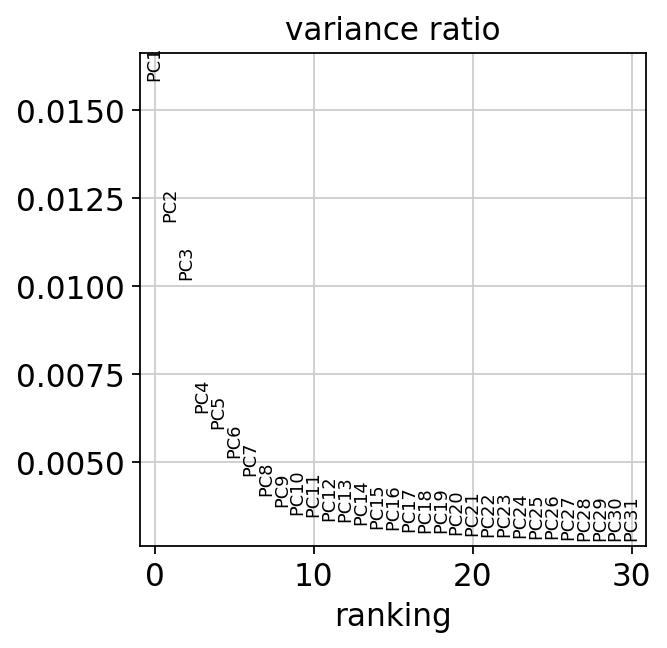

In [5]:
# Save the full normalized data before scaling/subsetting
adata.raw = adata

# Keep only highly variable genes for dimensionality reduction
adata = adata[:, adata.var.highly_variable]
print(f"Shape after HVG filtering: {adata.shape}") # Output: Shape after HVG filtering: (901, 2810)

# Scale data to zero mean and unit variance
sc.pp.scale(adata, max_value=10)

# Run Principal Component Analysis (PCA)
sc.tl.pca(adata, svd_solver='arpack')

# Plot variance explained by PCs to help choose the number to use later
sc.pl.pca_variance_ratio(adata, n_pcs=30, show=False) # Plot first 30 PCs
plt.show() # Output: [PCA variance ratio plot]

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP


/tmp/ipykernel_1378625/1175573617.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0) # resolution controls cluster granularity


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


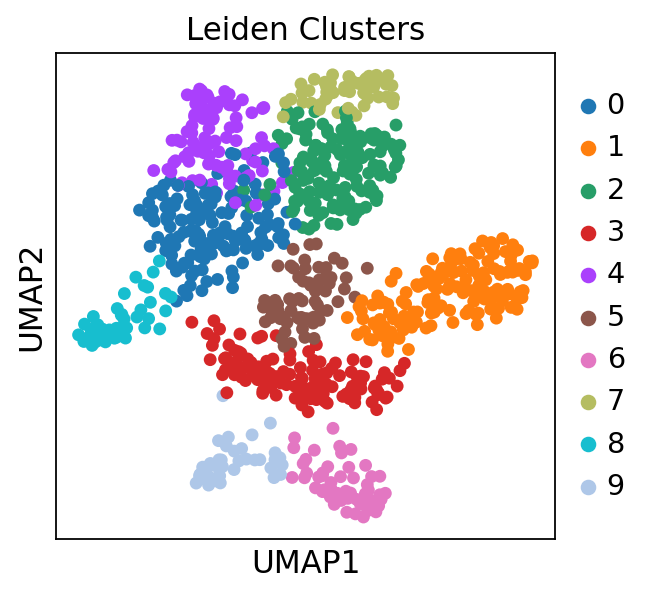

In [6]:
# Choose number of PCs (e.g., from elbow plot)
n_pcs_use = 15

# Compute nearest neighbor graph
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=n_pcs_use)

# Cluster cells using Leiden algorithm
sc.tl.leiden(adata, resolution=1.0) # resolution controls cluster granularity

# Compute UMAP embedding for visualization
sc.tl.umap(adata)

# Visualize clusters on UMAP
sc.pl.umap(adata, color='leiden', title='Leiden Clusters') # Output: [UMAP plot colored by clusters]
plt.show()

Finding marker genes...
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Plotting top marker genes...


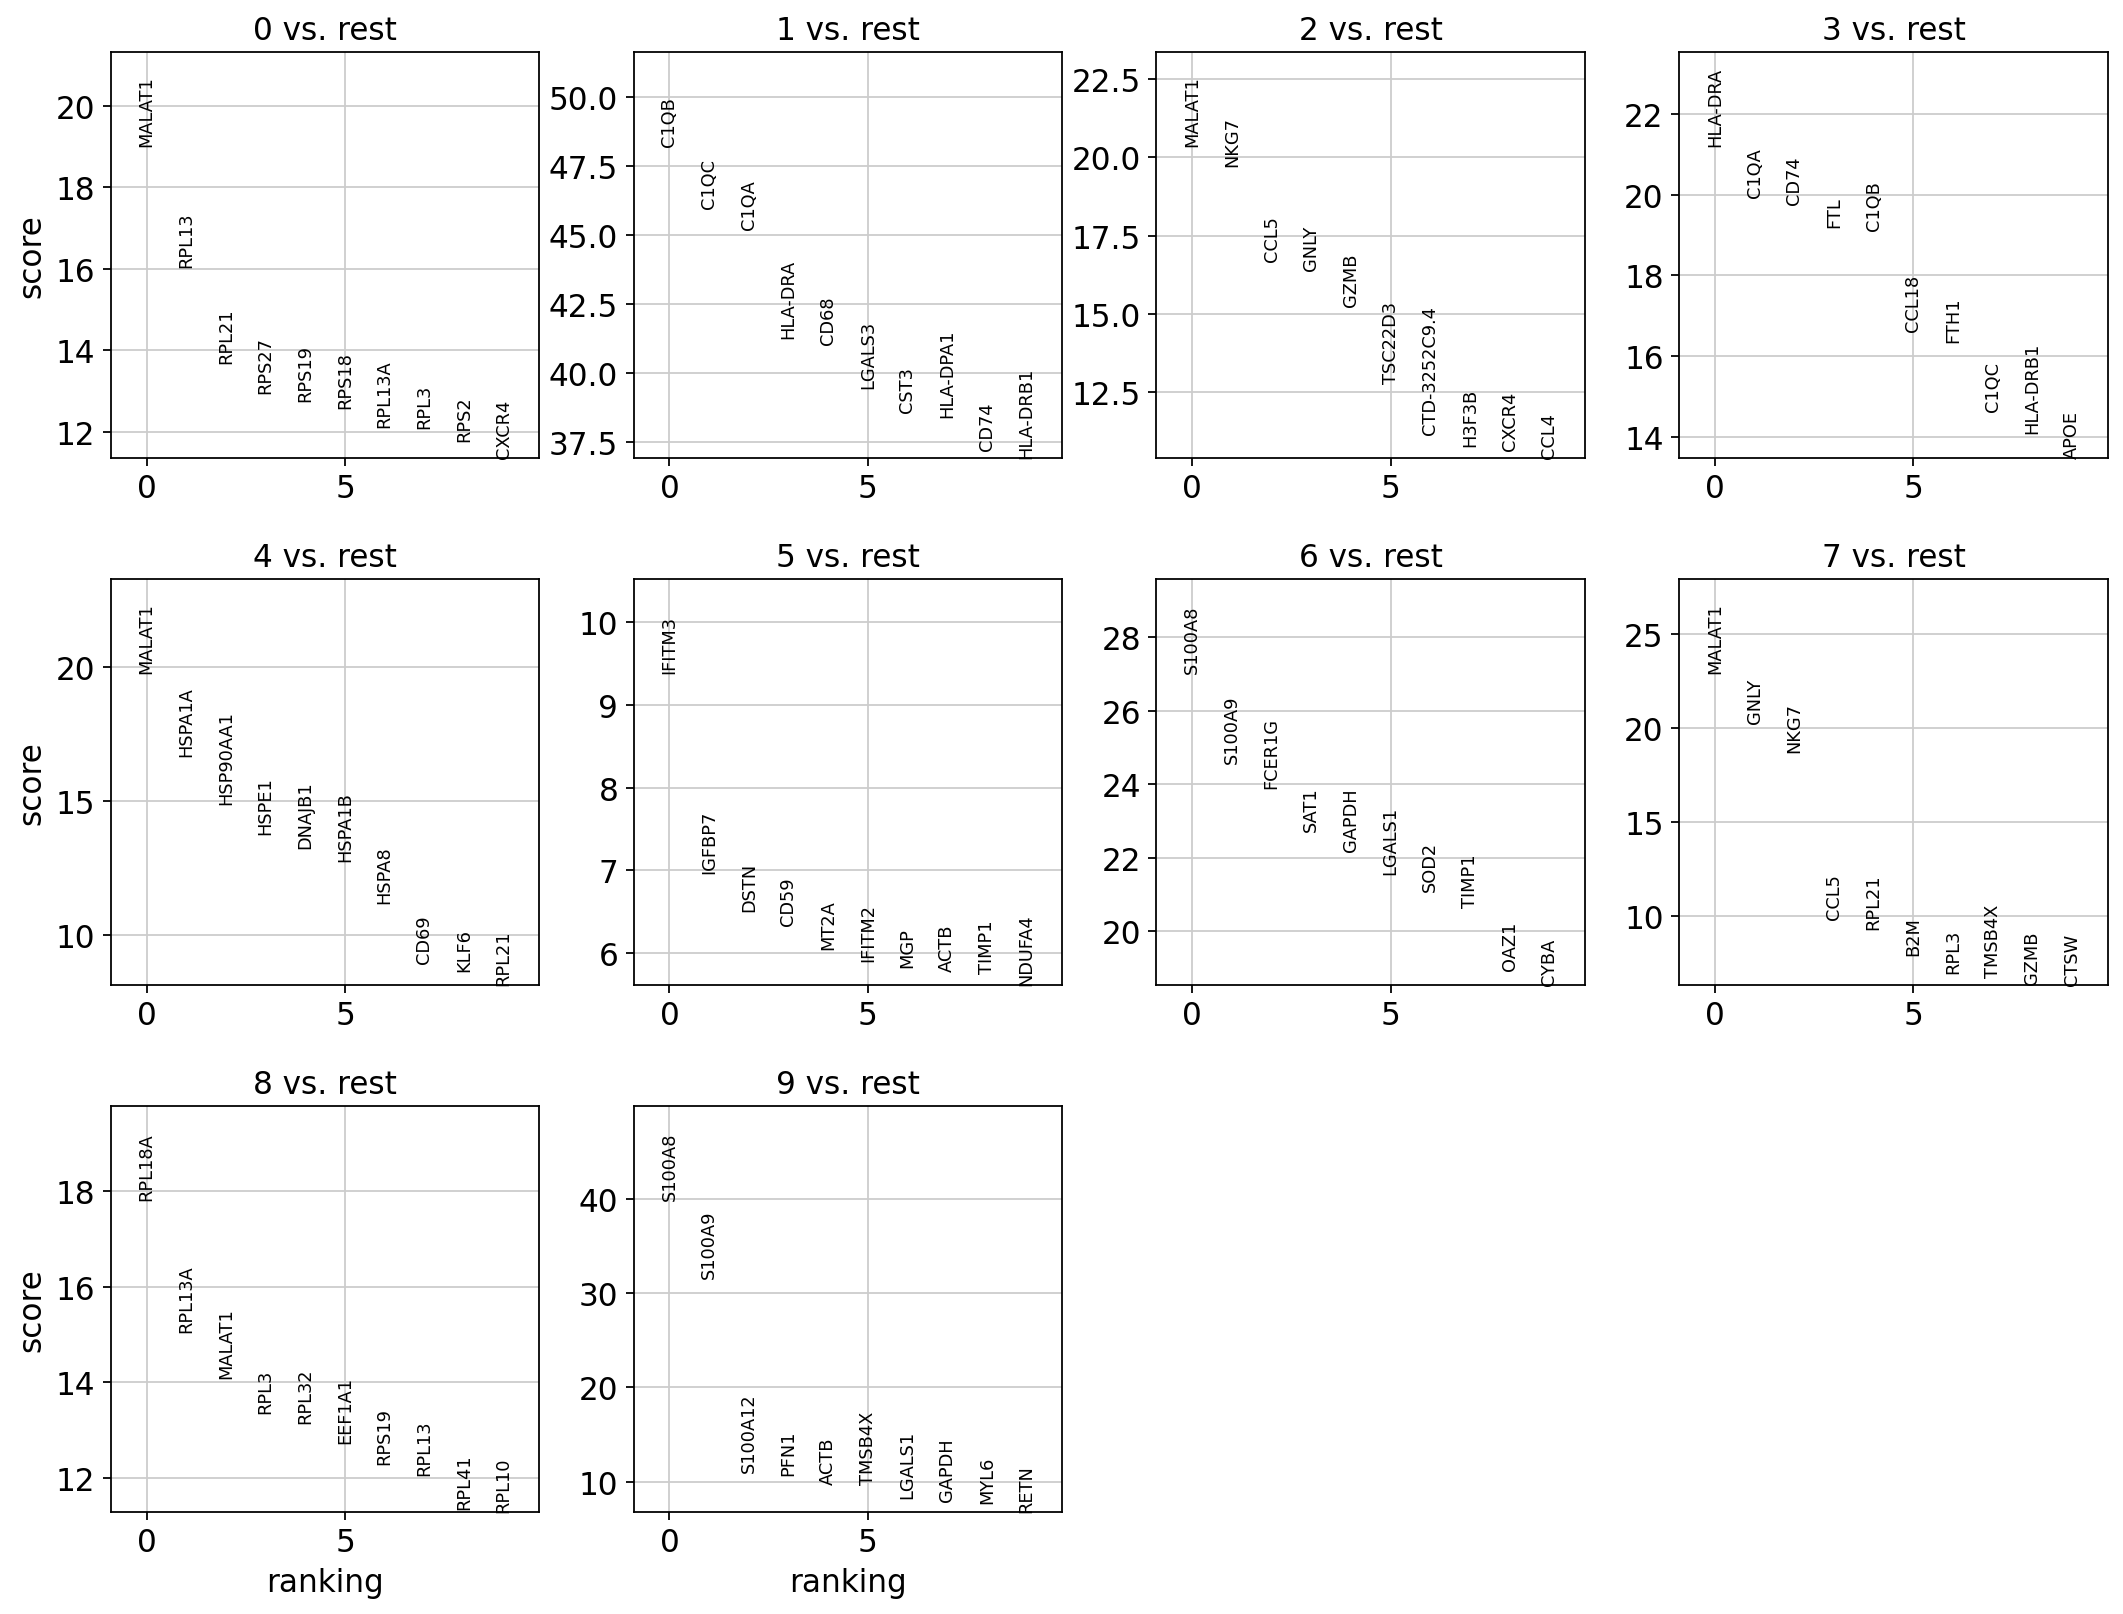

Saved top 25 markers summary to: top_25_markers_all_clusters.tsv


In [8]:
# Find genes that are upregulated in each cluster compared to all others
print("Finding marker genes...")
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# Plot the top genes for each cluster (e.g., top 10)
print("Plotting top marker genes...")
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False, show=False)
plt.show() # Output: [Marker gene dot plot]

# --- Optional: Save Top Markers Summary Table ---
gene_names_array = adata.uns['rank_genes_groups']['names']
markers_df = pd.DataFrame(gene_names_array)
top_25_markers_df = markers_df.head(25)
file_name = "top_25_markers_all_clusters.tsv"
top_25_markers_df.to_csv(file_name, sep='\t', index_label="rank")
print(f"Saved top 25 markers summary to: {file_name}")

Plotting UMAP with assigned cell types...


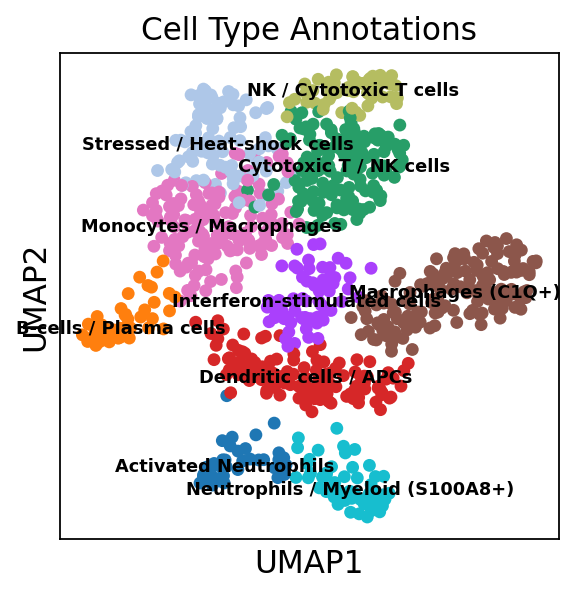


Annotation preview:
                 leiden                    cell_type
AAACCGTGGCGATT-1      2       Cytotoxic T / NK cells
AAACTTGACAGTTG-1      2       Cytotoxic T / NK cells
AAACTTGATCTCCG-1      2       Cytotoxic T / NK cells
AAAGATCTTTACTC-1      1           Macrophages (C1Q+)
AAAGGCCTAGAGAT-1      4  Stressed / Heat-shock cells


In [9]:
# Define cell type names based on your marker gene analysis (customize these!)
celltype_map = {
    0: 'Monocytes / Macrophages',       # e.g., High CD68, HLA-DRA
    1: 'Macrophages (C1Q+)',          # e.g., High C1QA/B/C
    2: 'Cytotoxic T / NK cells',      # e.g., High NKG7, GNLY, GZMB
    3: 'Dendritic cells / APCs',      # e.g., High HLA-DRA, CD74, CCL18
    4: 'Stressed / Heat-shock cells', # e.g., High HSPA1A, DNAJB1
    5: 'Interferon-stimulated cells', # e.g., High IFITM3, ISG15
    6: 'Neutrophils / Myeloid (S100A8+)', # e.g., High S100A8, S100A9
    7: 'NK / Cytotoxic T cells',      # e.g., Similar markers to cluster 2
    8: 'B-cells / Plasma cells',      # e.g., High IGKC (Refined later)
    9: 'Activated Neutrophils'       # e.g., High S100A8/A9, other markers?
}

# Add these names as a new 'cell_type' column in the cell metadata
adata.obs['cell_type'] = adata.obs['leiden'].astype(int).map(celltype_map).astype('category')

# Visualize the UMAP again, now colored by your assigned cell types
print("Plotting UMAP with assigned cell types...")
sc.pl.umap(adata, color='cell_type',
           title='Cell Type Annotations',
           legend_loc='on data', # Place labels directly on clusters
           legend_fontsize=8) # Adjust font size if needed
plt.show() # Output: [Annotated UMAP plot]

# Check the first few cells to see their cluster and assigned type
print("\nAnnotation preview:")
print(adata.obs[['leiden', 'cell_type']].head()) 

Plotting key marker expression...
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


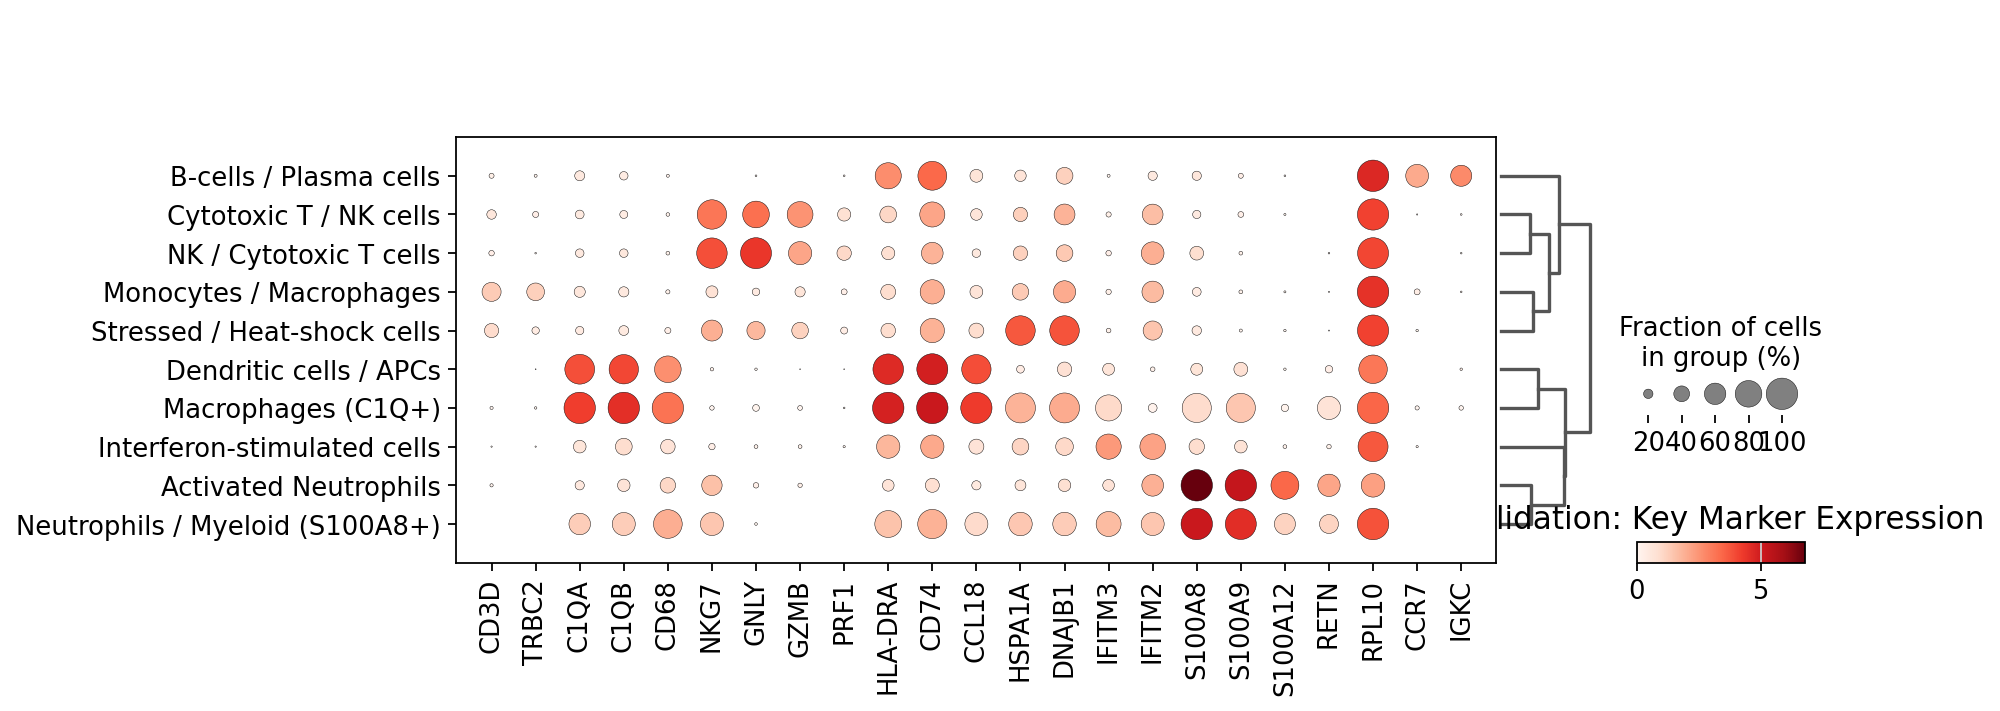

In [11]:

# Define a list of well-known marker genes for expected cell types
key_markers = [
    'CD3D','TRBC2', # T-cell markers
    'C1QA','C1QB','CD68', # Macrophage / APC markers
    'NKG7','GNLY','GZMB','PRF1', # Cytotoxic / NK markers
    'HLA-DRA','CD74','CCL18', # APC / DC markers
    'HSPA1A','DNAJB1', # Stressed cell markers
    'IFITM3','IFITM2', # Interferon response markers
    'S100A8','S100A9','S100A12','RETN', # Neutrophil markers
    'RPL10', 'CCR7','IGKC' # B-cell / Proliferative markers
]

# Ensure categorical types are clean before plotting
adata.obs['cell_type'] = adata.obs['cell_type'].cat.remove_unused_categories()

# Create a dot plot to check expression patterns
print("Plotting key marker expression...")
sc.pl.dotplot(adata, key_markers, groupby='cell_type', dendrogram=True, show=False)
plt.title("Validation: Key Marker Expression")
plt.show() # Output: [Dot plot showing expression across cell types]

Plotting final annotated UMAP...


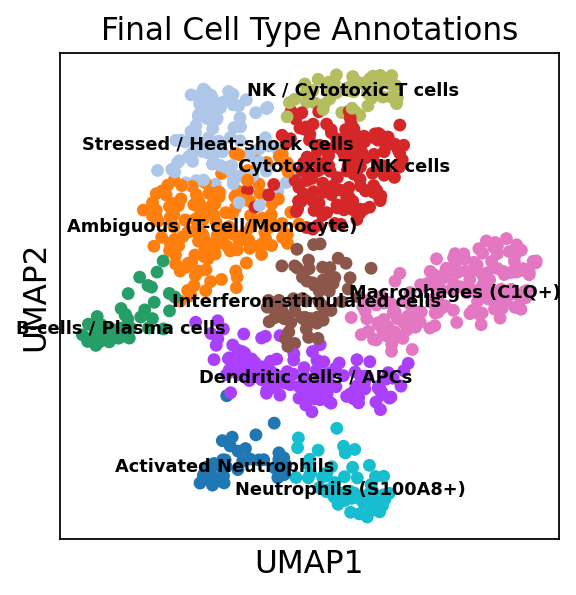

In [12]:
# Refine cell type names based on validation (e.g., correct Cluster 8, note ambiguity)
celltype_map_final = {
    0: 'Ambiguous (T-cell/Monocyte)', # Had mixed markers
    1: 'Macrophages (C1Q+)',
    2: 'Cytotoxic T / NK cells',
    3: 'Dendritic cells / APCs',
    4: 'Stressed / Heat-shock cells',
    5: 'Interferon-stimulated cells',
    6: 'Neutrophils (S100A8+)',
    7: 'NK / Cytotoxic T cells',
    8: 'B-cells / Plasma cells',     # Confirmed by IGKC
    9: 'Activated Neutrophils'
}

# Overwrite the 'cell_type' column with refined names
adata.obs['cell_type'] = adata.obs['leiden'].astype(int).map(celltype_map_final).astype('category')

# Plot the final UMAP with refined annotations
print("Plotting final annotated UMAP...")
sc.pl.umap(adata, color='cell_type',
           title='Final Cell Type Annotations',
           legend_loc='on data',
           legend_fontsize=8,
           show=False)
plt.show() # Output: [Final UMAP plot with refined labels]

Running DE analysis between neutrophil subsets...
ranking genes
    finished: added to `.uns['neutrophil_activation']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Generating volcano plot...


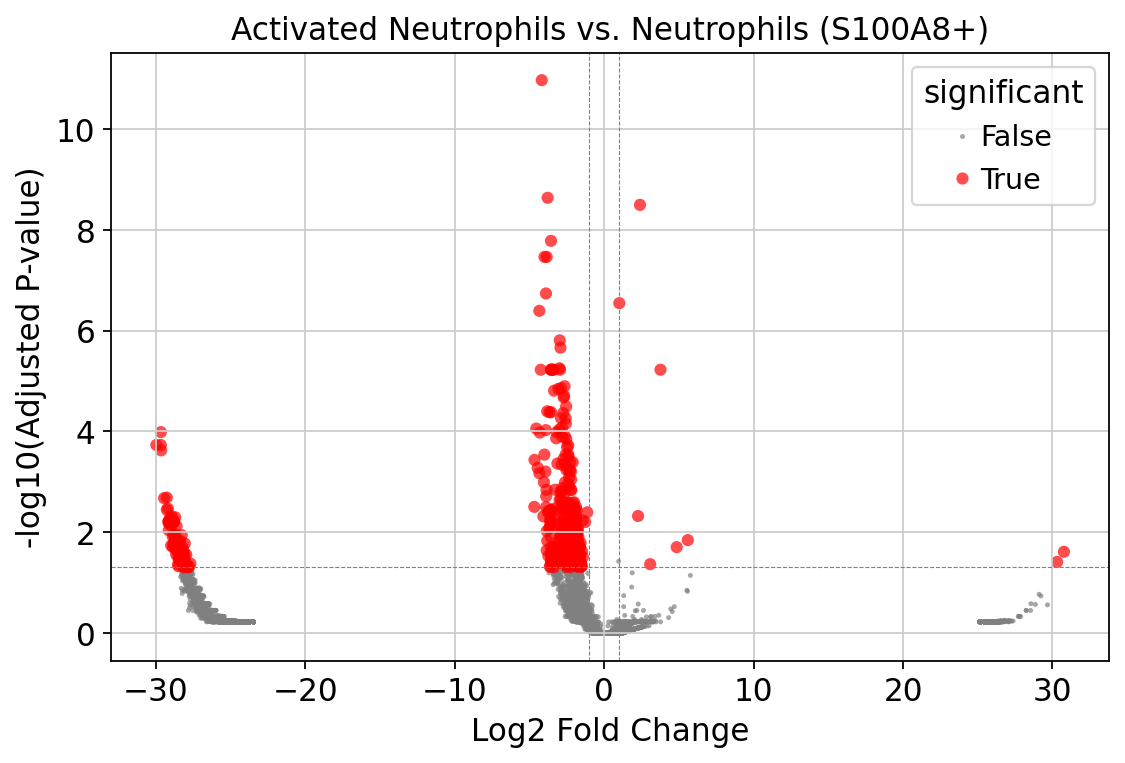

In [13]:

# Compare 'Activated Neutrophils' vs 'Neutrophils (S100A8+)'
print("Running DE analysis between neutrophil subsets...")
sc.tl.rank_genes_groups(adata,
                        groupby='cell_type',
                        groups=['Activated Neutrophils'],      # Group to test
                        reference='Neutrophils (S100A8+)',  # Comparison group
                        method='t-test',
                        key_added='neutrophil_activation') # Save results under this key

# --- Prepare and Create Volcano Plot ---
# Get the DE results into a DataFrame
neutrophil_de_df = sc.get.rank_genes_groups_df(adata,
                                               key='neutrophil_activation',
                                               group='Activated Neutrophils')

# Calculate significance (-log10 adjusted p-value)
# Add a small epsilon to avoid log10(0)
neutrophil_de_df['-log10_pvals_adj'] = -np.log10(neutrophil_de_df['pvals_adj'] + 1e-300)

# Mark genes as significant based on fold change and p-value
neutrophil_de_df['significant'] = (
    (neutrophil_de_df['logfoldchanges'].abs() > 1) & # Log2 Fold Change > 1 (or < -1)
    (neutrophil_de_df['pvals_adj'] < 0.05)           # Adjusted P-value < 0.05
)

# Create the volcano plot
print("Generating volcano plot...")
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=neutrophil_de_df,
    x='logfoldchanges',
    y='-log10_pvals_adj',
    hue='significant', # Color significant genes
    palette={True: 'red', False: 'grey'},
    size='significant', # Make significant genes larger
    sizes={True: 30, False: 5},
    alpha=0.7, edgecolor='none'
)
plt.title('Activated Neutrophils vs. Neutrophils (S100A8+)')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(Adjusted P-value)')
# Add threshold lines
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--', linewidth=0.5)
plt.show() # Output: [Volcano plot showing DE genes]

Analyzing trajectory for 94 cells
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [ 1.          0.9714591   0.9115418   0.82433     0.77181137  0.73765963
      0.6815183   0.6150026   0.57866323  0.5267857   0.48960435 -0.47217843
     -0.4958326  -0.5018282  -0.52452135]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
Set root for DPT in Neutrophils (S100A8+)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


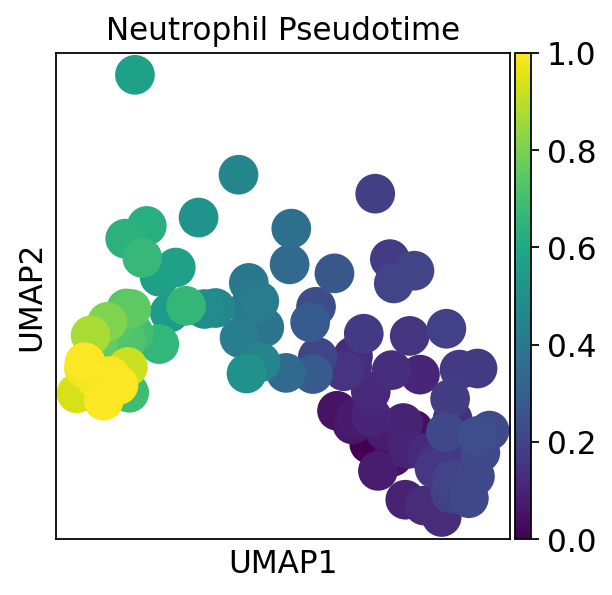

/home/ibab/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/ibab/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


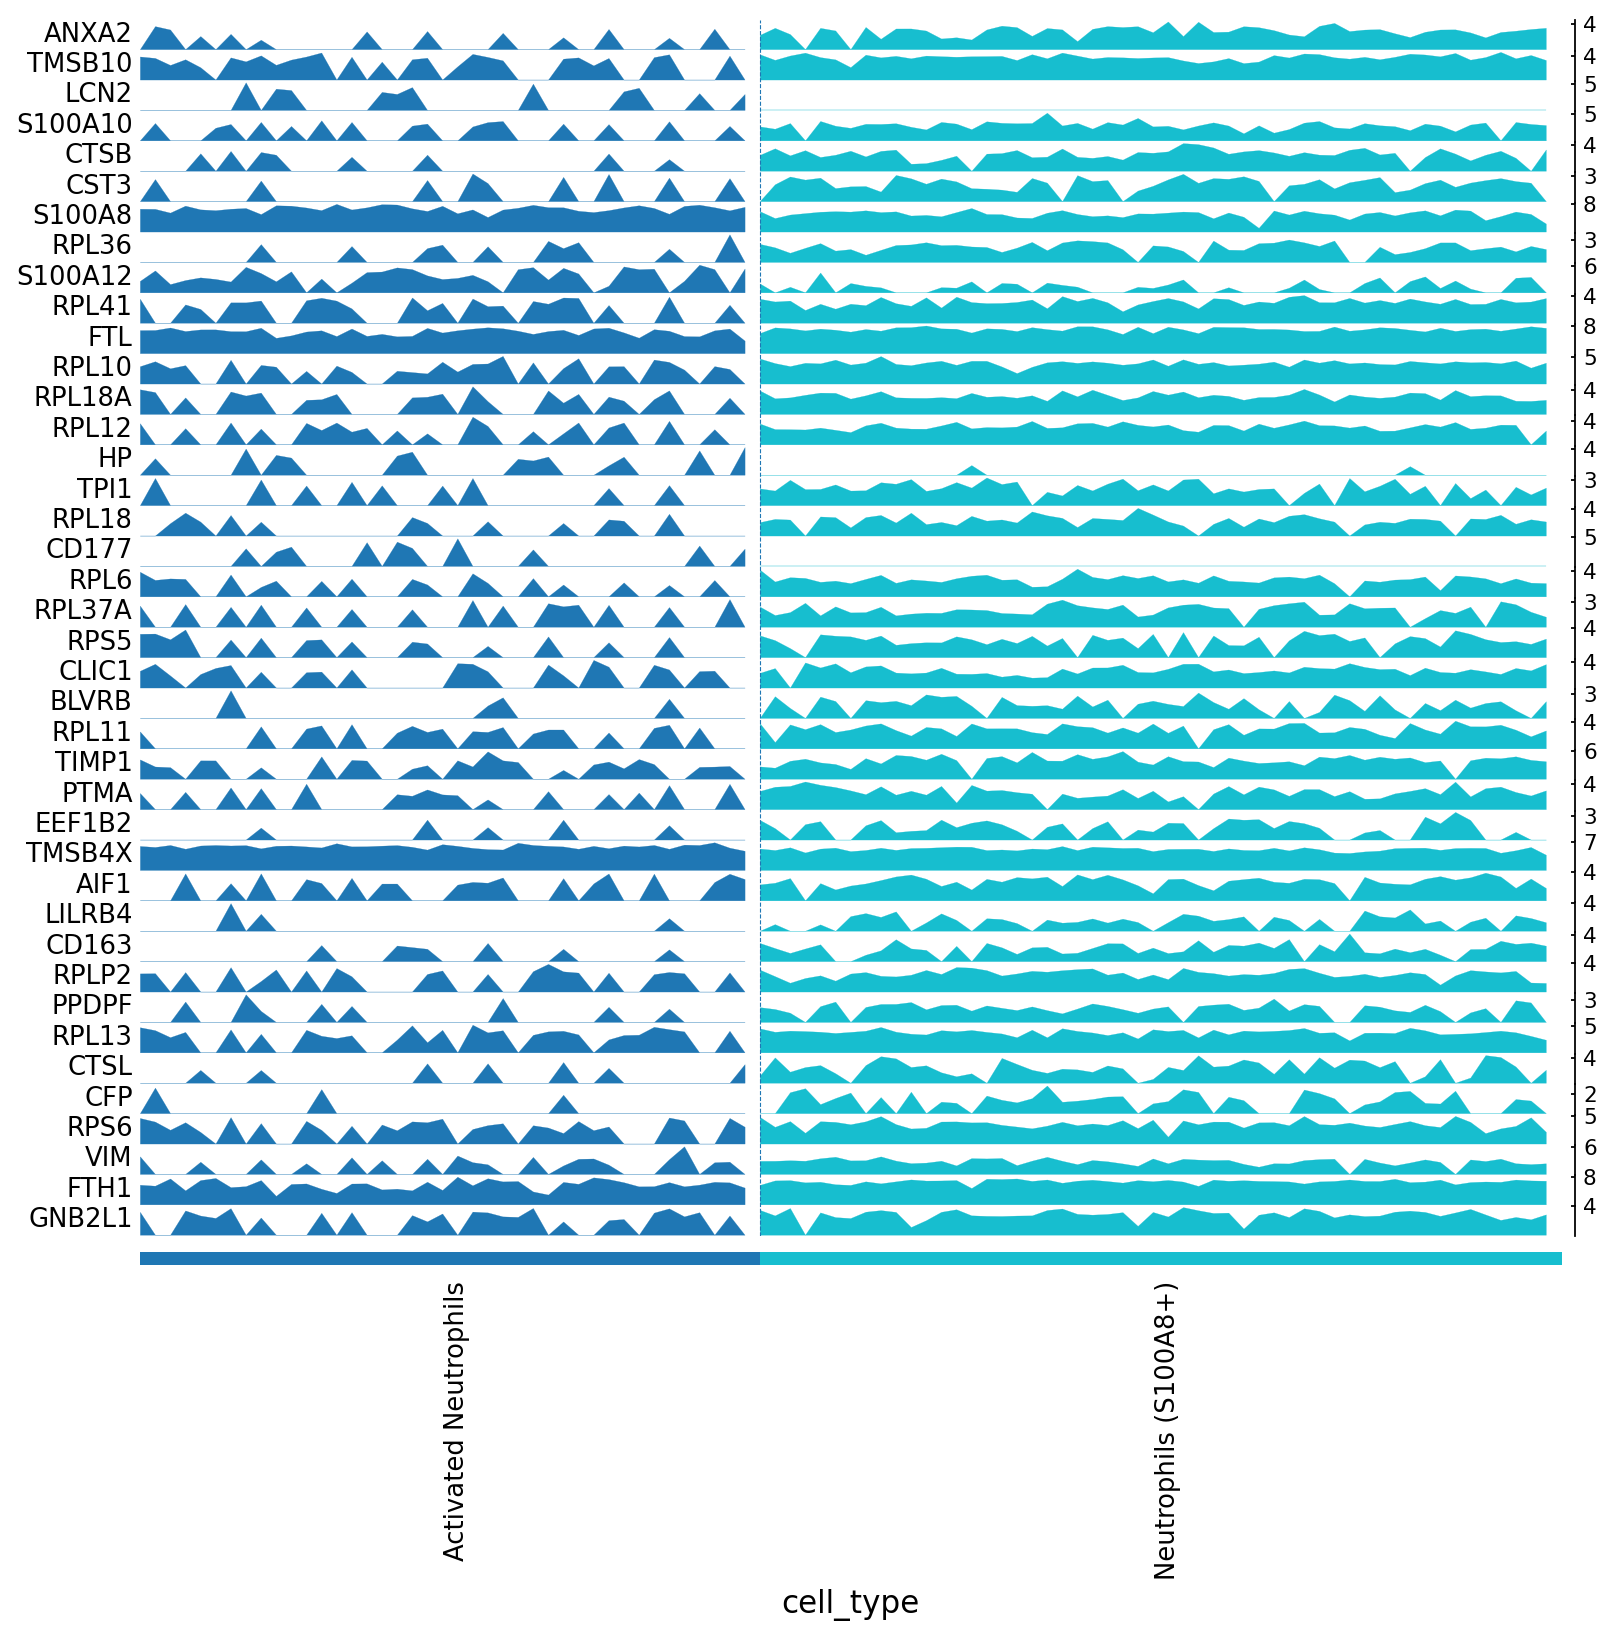

In [14]:

# Define the cell types for the trajectory
myeloid_lineage = ['Neutrophils (S100A8+)', 'Activated Neutrophils']

# Create a subset AnnData object containing only these cells
adata_neutrophil = adata[adata.obs['cell_type'].isin(myeloid_lineage)].copy()
print(f"Analyzing trajectory for {adata_neutrophil.n_obs} cells") # Output: Analyzing trajectory for 94 cells

# --- Recompute Neighbors and Diffusion Map for the Subset ---
# Important: Calculations change when looking at a subset
sc.pp.neighbors(adata_neutrophil, n_pcs=15, n_neighbors=10) # Using 15 PCs from earlier
sc.tl.diffmap(adata_neutrophil)

# --- Define Root and Run Diffusion Pseudotime (DPT) ---
# Set the "start" of the trajectory (the resting state)
root_cell_type_name = 'Neutrophils (S100A8+)'
try:
    # Find the index of the first cell of the root type
    root_cell_index = np.where(adata_neutrophil.obs['cell_type'] == root_cell_type_name)[0][0]
    adata_neutrophil.uns['iroot'] = root_cell_index # Store root index
    print(f"Set root for DPT in {root_cell_type_name}")

    # Calculate pseudotime distance from the root
    sc.tl.dpt(adata_neutrophil)

    # Visualize pseudotime on the subset's UMAP
    sc.pl.umap(adata_neutrophil, color='dpt_pseudotime', cmap='viridis', title='Neutrophil Pseudotime') # Output: [UMAP colored by pseudotime]
    plt.show()

    # --- Find and Plot Genes Changing Along Pseudotime ---
    # Calculate correlation between gene expression (.raw data) and pseudotime
    pseudotime = adata_neutrophil.obs['dpt_pseudotime']
    expression = pd.DataFrame(adata_neutrophil.raw.X.toarray(),
                              index=adata_neutrophil.obs_names,
                              columns=adata_neutrophil.raw.var_names)
    correlations = expression.corrwith(pseudotime)
    strongest_corrs = correlations.abs().sort_values(ascending=False)
    top_genes = strongest_corrs.head(40).index.tolist() # Get top 40 correlated genes

    # Plot expression trends of these genes along the trajectory
    sorted_cell_indices = adata_neutrophil.obs.sort_values(by='dpt_pseudotime').index
    sc.pl.tracksplot(adata_neutrophil, top_genes,
                     groupby='cell_type',
                     obs_order=sorted_cell_indices, # Order cells by pseudotime
                     use_raw=True, # Use non-scaled data for visualization
                     dendrogram=False,
                     cmap='viridis',
                     standard_scale='var', # Scale each gene for pattern visibility
                     title='Top Genes Along Neutrophil Pseudotime',
                     show=False)
    plt.show() # Output: [Tracksplot heatmap]

except IndexError:
    print(f"Error: Could not find root cells of type {root_cell_type_name}. Skipping DPT.")
except Exception as e:
    print(f"An error occurred during DPT analysis: {e}")

In [15]:
# Import the GProfiler library
from gprofiler import GProfiler

# --- Get DE gene lists from volcano plot results ---
# Genes significantly upregulated in 'Activated Neutrophils'
turned_on_genes = neutrophil_de_df[
    (neutrophil_de_df['logfoldchanges'] > 1) &
    (neutrophil_de_df['pvals_adj'] < 0.05)
]['names'].tolist()

# Genes significantly downregulated in 'Activated Neutrophils' (i.e., higher in resting)
shutoff_genes = neutrophil_de_df[
    (neutrophil_de_df['logfoldchanges'] < -1) &
    (neutrophil_de_df['pvals_adj'] < 0.05)
]['names'].tolist()

# --- Initialize GProfiler ---
gp = GProfiler(return_dataframe=True)

# --- Run enrichment for TURNED ON genes ---
print("\n--- Pathways TURNED ON (Upregulated in Activated Neutrophils) ---")
if turned_on_genes: # Check if the list is not empty
    try:
        late_pathways = gp.profile(organism='hsapiens',
                                   query=turned_on_genes,
                                   sources=['GO:BP', 'REAC', 'KEGG']) # Query specific databases
        print(late_pathways.sort_values(by='p_value').head(10)) # Print top 10 results
    except Exception as e:
        print(f"GProfiler query failed for turned_on_genes: {e}")
else:
    print("No significantly upregulated genes found for pathway analysis.")

# --- Run enrichment for SHUT OFF genes ---
print("\n--- Pathways SHUT OFF (Downregulated in Activated Neutrophils) ---")
if shutoff_genes: # Check if the list is not empty
    try:
        early_pathways = gp.profile(organism='hsapiens',
                                    query=shutoff_genes,
                                    sources=['GO:BP', 'REAC', 'KEGG'])
        print(early_pathways.sort_values(by='p_value').head(10)) # Print top 10 results
    except Exception as e:
        print(f"GProfiler query failed for shutoff_genes: {e}")
else:
    print("No significantly downregulated genes found for pathway analysis.")


--- Pathways TURNED ON (Upregulated in Activated Neutrophils) ---
  source              native                                           name  \
0  GO:BP          GO:0006952                               defense response   
1  GO:BP          GO:0009605                  response to external stimulus   
2  GO:BP          GO:0050727            regulation of inflammatory response   
3  GO:BP          GO:0006954                          inflammatory response   
4   REAC  REAC:R-HSA-6798695                       Neutrophil degranulation   
5   REAC  REAC:R-HSA-6799990  Metal sequestration by antimicrobial proteins   
6  GO:BP          GO:0042742                  defense response to bacterium   
7  GO:BP          GO:0031347                 regulation of defense response   
8  GO:BP          GO:1990266                           neutrophil migration   
9  GO:BP          GO:0006950                             response to stress   

    p_value  significant                                       

In [16]:
# Import the specific LIANA method and plotting function
from liana.method import cellphonedb
import liana.pl as lipl
import scipy.sparse # Needed for checking matrix type

# --- Prepare Data for LIANA ---
# LIANA needs non-log, normalized data with ALL genes
print("Preparing data for LIANA...")
adata_liana = adata.raw.to_adata() # Create object from saved raw data
adata_liana.obs['cell_type'] = adata.obs['cell_type'] # Copy final cell type annotations

# Reverse the log1p transform to get normalized counts
log_counts = adata_liana.X
if scipy.sparse.issparse(log_counts):
    normalized_counts = log_counts.expm1()
else: # If it's a dense numpy array
    normalized_counts = np.expm1(log_counts)
# Store in a new layer
adata_liana.layers['normalized_counts'] = normalized_counts
print("Created 'normalized_counts' layer in adata_liana.")

# --- Run LIANA with CellPhoneDB Method ---
print("Running LIANA analysis (CellPhoneDB method)...")
# Run the analysis, grouping by our final cell types
results = cellphonedb(
    adata_liana,
    groupby='cell_type',
    layer='normalized_counts', # Use the non-log data
    use_raw=False,
    resource_name='cellphonedb', # Specify the interaction database
    verbose=False, # Make output less noisy
    inplace=False # Return results instead of modifying object directly
)
# Store the results in the .uns slot
adata_liana.uns['liana_res'] = results
print("LIANA analysis finished. Results stored in adata_liana.uns['liana_res']")

# --- Filter and Plot Top CCC Interactions ---
# Get the results table
liana_res_df = adata_liana.uns['liana_res'].copy()

# Sort results by CellPhoneDB p-value (lower is more significant)
liana_res_df_sorted = liana_res_df.sort_values(by='cellphone_pvals', ascending=True)

# Select the top 25 interactions
top_interactions = liana_res_df_sorted.head(25)

# Check if any significant interactions were found
if not top_interactions.empty:
    # Prepare a size column based on p-value for plotting
    top_interactions['-log10_pval'] = -np.log10(top_interactions['cellphone_pvals'] + 1e-10) # Add epsilon

    # Create the dot plot
    print("Plotting top CCC interactions...")
    p_ccc = lipl.dotplot(
        liana_res=top_interactions, # Plot the filtered results
        colour='lr_means',          # Color dots by interaction strength
        size='-log10_pval',       # Size dots by significance
        figure_size=(10, 6)       # Adjust figure size
    )
    print(p_ccc) # Render the plot object
    plt.show() # Ensure plot is displayed # Output: [CCC dot plot]

    # Save the results table
    top_interactions.to_csv("top_25_ccc_interactions.tsv", sep='\t', index=False)
    print("Saved top 25 CCC interactions table.")
else:
    print("No significant interactions found by LIANA/CellPhoneDB.")

Preparing data for LIANA...
Created 'normalized_counts' layer in adata_liana.
Running LIANA analysis (CellPhoneDB method)...


/home/ibab/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/home/ibab/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


LIANA analysis finished. Results stored in adata_liana.uns['liana_res']
Plotting top CCC interactions...
<ggplot: (1000 x 600)>
Saved top 25 CCC interactions table.


/tmp/ipykernel_1378625/1668319643.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Plotting cell type composition...


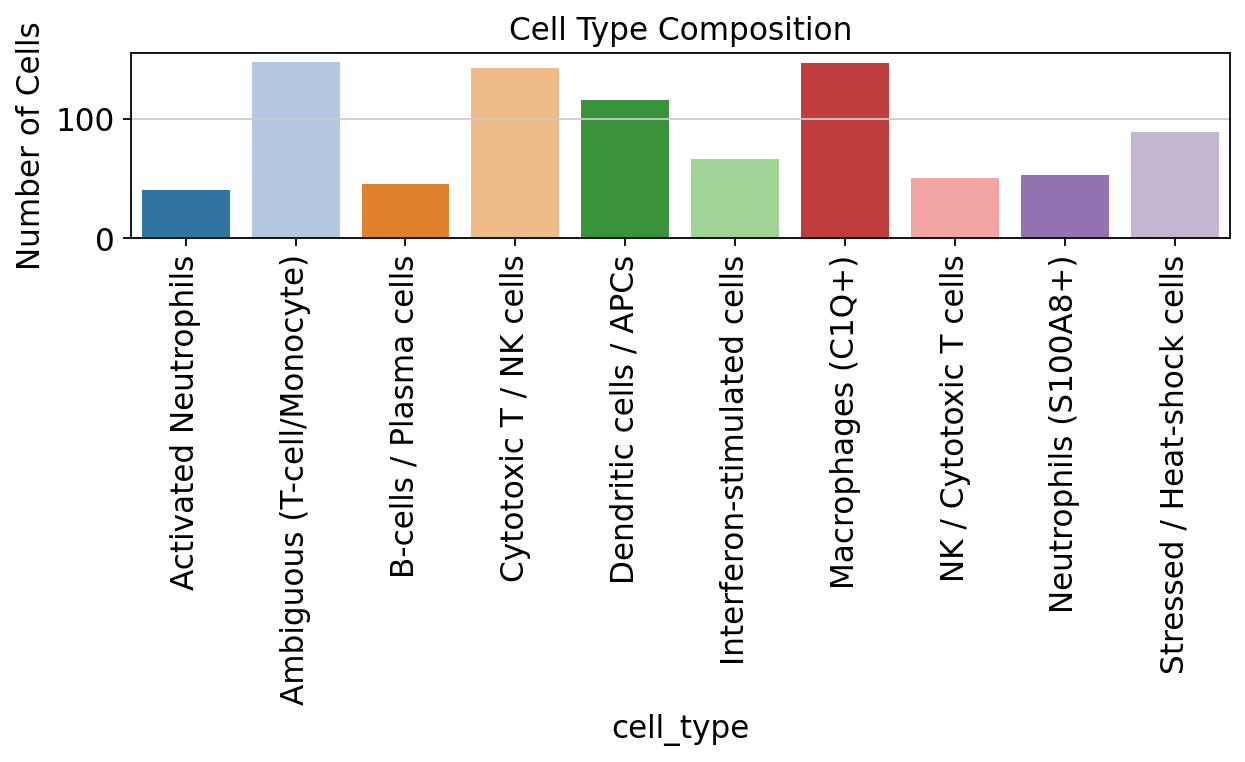

Saving final AnnData objects...
Saving environment file...
Saved environment to requirements.txt


In [17]:
# --- Plot Cell Type Composition ---
print("Plotting cell type composition...")
cell_counts = adata.obs['cell_type'].value_counts()
plt.figure(figsize=(8, 5))
# Use hue=x for newer seaborn versions to avoid warnings
sns.barplot(x=cell_counts.index, y=cell_counts.values, palette="tab20", hue=cell_counts.index, legend=False)
plt.title('Cell Type Composition')
plt.ylabel('Number of Cells')
plt.xticks(rotation=90) # Rotate labels for readability
plt.tight_layout() # Adjust layout
plt.show() # Output: [Cell composition bar plot]

# --- Save Final AnnData Objects ---
# Save the main annotated object (HVGs only)
print("Saving final AnnData objects...")
adata.write_h5ad("GSE128033_final_annotated.h5ad")

# Save the neutrophil trajectory object (if it exists)
if 'adata_neutrophil' in locals():
    adata_neutrophil.write_h5ad("neutrophil_trajectory_analysis.h5ad")

# Save the object used for LIANA (all genes)
adata_liana.write_h5ad("liana_ccc_analysis.h5ad")

# --- Save Python Environment ---
print("Saving environment file...")
# Use Python subprocess to run pip freeze for better compatibility
import sys
import subprocess
try:
    # Open requirements.txt for writing
    with open("requirements.txt", "w") as f:
        # Run 'pip freeze' and write output to the file
        subprocess.run([sys.executable, '-m', 'pip', 'freeze'], stdout=f, check=True)
    print("Saved environment to requirements.txt") # Output: Saved environment...
except Exception as e:
    print(f"Could not save requirements.txt: {e}") # Print error if saving fails

In [18]:
# Uses the neighbor graph computed earlier and the final cell type annotations
print("Running PAGA...")
sc.tl.paga(adata, groups='cell_type')

print("PAGA calculation complete.")

Running PAGA...
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
PAGA calculation complete.


Plotting PAGA graph...
--> added 'pos', the PAGA positions (adata.uns['paga'])


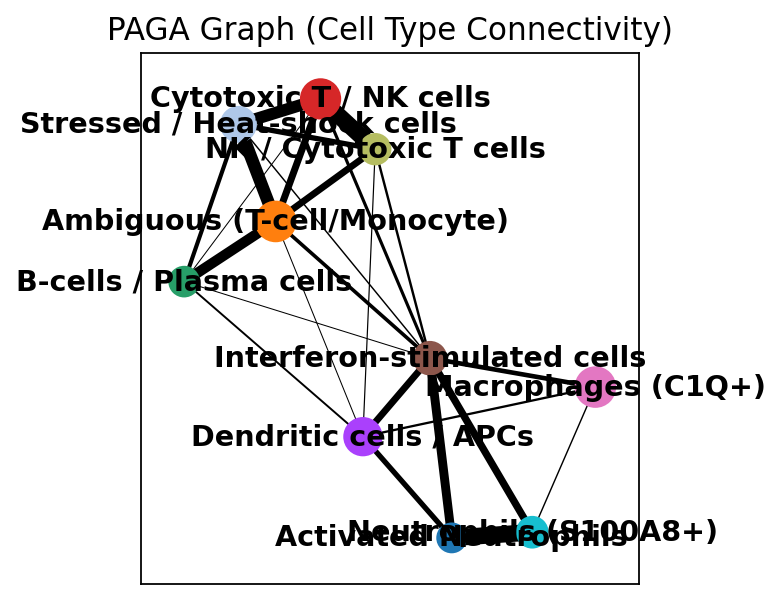

In [19]:
print("Plotting PAGA graph...")
sc.pl.paga(adata,
           threshold=0.03,        # Show connections stronger than this threshold
           node_size_scale=1.5,   # Adjust node size
           layout='fr',           # Use Fruchterman-Reingold layout
           show=False,            # Don't show immediately
           title="PAGA Graph (Cell Type Connectivity)")
plt.show() # Display the plot # Output: [PAGA graph plot]

Plotting UMAP with PAGA overlay...


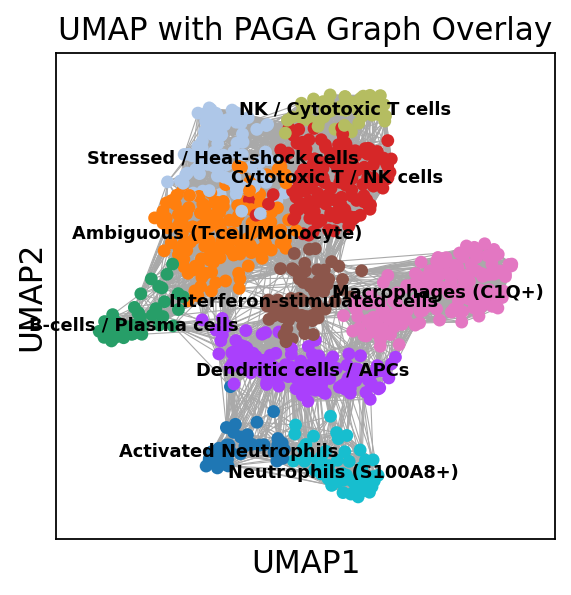

In [20]:
# --- Plot PAGA graph overlaid on UMAP ---
print("Plotting UMAP with PAGA overlay...")
sc.pl.umap(adata, color='cell_type',
           title='UMAP with PAGA Graph Overlay',
           legend_loc='on data',
           legend_fontsize=8,
           edges=True,            # Draw PAGA connections as lines
           edges_width=0.5,       # Adjust line width
           edges_color='darkgrey', # Adjust line color
           show=False)
plt.show() # Display the plot # Output: [UMAP with PAGA overlay]